In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%pip install scipy==1.2

In [3]:
# # This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = "W8_Assignment"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

/content/drive/My Drive/W8_Assignment/cs231n/datasets
--2021-06-19 02:31:34--  http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  28.2MB/s    in 6.6s    

2021-06-19 02:31:41 (24.8 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1
/content/drive/My Drive/W8_Assignment


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [4]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [5]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


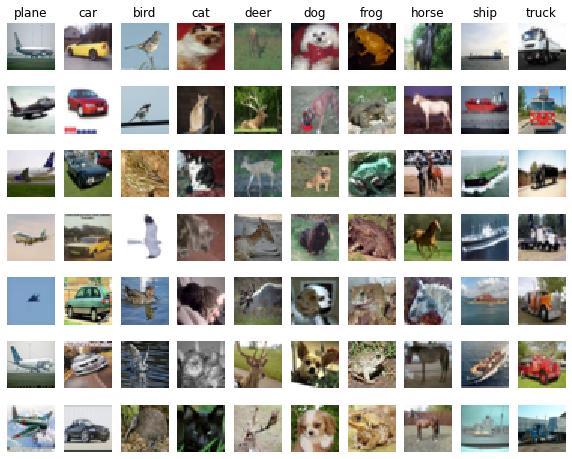

In [6]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [7]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [8]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [9]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


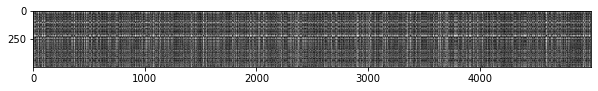

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question 1** 

Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$   
- Q : What in the data is the cause behind the distinctly bright rows?  
  A : Bright rows indicates there' no similar images in the train data or might be the case that there's no class for that test data. (Distances between a test image and train data are big).   
  행의 색이 밝은 이유는 트레인 데이터와 테스트 이미지 사이의 거리가 멀어서입니다. 테스트 이미지와 비슷한 트레인 데이터가 없을 경우 행 전체가 대체적으로 밝은 색을 띄게 됩니다. 즉 트레인 데이트에 비슷한 이미지가 없거나 트레인 데이터에 없는 클래스일 경우에 행 전체가 밝은 색을 갖게 됩니다.

- Q : What causes the columns?  
  A : 질문이 정확히 무슨 의미인지 모르겠어서, 1번 질문과 유사하게 특정 column의 색이 밝은 이유라고 생각하고 답하겠습니다.  
  Some columns are brighter than the others because there's no similar data in the test set.  
  테스트 데이터 셋에서 해당 열의 이미지와 유사한 이미지가 없기 때문에 l2 norm의 값이 커서 밝은 색을 띄게 됩니다.



In [11]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [12]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 136 / 500 correct => accuracy: 0.272000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$, 

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is 
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply.
1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data.

$\color{blue}{\textit Your Answer:}$  1, 2


$\color{blue}{\textit Your Explanation:}$  
Shifting the data by mean($\mu$) does not affect to the performance of  NN classifiers that uses L1 distance. However, dividing by the std($\sigma$) means the value is scaled which might affect the perfomance because the value is changed. Furthermore, L1 distance is the sum of distance of x-axis and y-axis. Therefore, if the coordinate is rotated, the distance of x-axis and y-axis might change unless the rotation angle is multiple of $\pi \over 2$.  

데이터를 평균($\mu$)만큼 옮기는 것은 L1 거리를 사용하는 NN Classifier의 성능(결과)에 영향을 미치지 않기 때문에 1번과 2번이 답입니다. 하지만, 표준편차($\sigma$)로 값을 나누게 된다면 결과에 어떠한 값이 곱해짐으로써 기존과 결과 값이 달라져 성능에 영향을 미치게 됩니다. 그리고 5번 축 회전의 경우, 90도, 180도와 같이 회전을 하면 결과 값이 영향을 받지 않겠지만, 그 외의 일반적인 경우 x축과 y축의 값을 더한 것이 L1 Distance를 구하는 방법으로 축회전을 하면서 거리가 변하게 되어 NN Classfier의 결과 값이 바뀌게 됩니다.

   
Let's say x and y are two arbitrary data.  

-  Original method to get L1 distance : $$ | x - y | $$

- When subtracting the mean $\mu$ : (1, 2) - The distance is same.
$$ |(x - \mu) - (y - \mu) | = | x - y | $$


- When subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$ : (3, 4) - The distance is different
$$ |{(x - \mu) \over \sigma} - {(y - \mu) \over \sigma} | = {1 \over \sigma}| x - y | $$

In [13]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [14]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
print(X_test.shape)
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

(500, 3072)
No loop difference was: 0.000000
Good! The distance matrices are the same


In [15]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using, 
# you might not see a speedup when you go from two loops to one loop, 
# and might even see a slow-down.

Two loop version took 38.377153 seconds
One loop version took 19.766138 seconds
No loop version took 0.444661 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [16]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for k in k_choices : #{

    for i in range(num_folds) : #{
        X_train_data = np.concatenate(X_train_folds[:i] + X_train_folds[i+1:])    
        y_train_data = np.concatenate(y_train_folds[:i] + y_train_folds[i+1:])

        X_val_data = X_train_folds[i]
        y_val_data = y_train_folds[i]

        classifier.train(X_train_data, y_train_data)

        y_pred  = classifier.predict(X_val_data, k=k)
        accuracy = np.mean(y_pred == y_val_data)
        k_to_accuracies[k] = k_to_accuracies.get(k, []) + [accuracy]
    #}
#}

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 3, accuracy = 0.269000
k = 3, accuracy = 0.270000
k = 3, accuracy = 0.275000
k = 3, accuracy = 0.282000
k = 5, accuracy = 0.267000
k = 5, accuracy = 0.281000
k = 5, accuracy = 0.287000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.283000
k = 8, accuracy = 0.263000
k = 8, accuracy = 0.296000
k = 8, accuracy = 0.286000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.284000
k = 10, accuracy = 0.269000
k = 10, accuracy = 0.308000
k = 10, accuracy = 0.290000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.279000
k = 12, accuracy = 0.265000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.281000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.266000
k = 15, accuracy = 0.296000
k = 15, accuracy = 0.285000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 20, accuracy = 0.265000
k = 20, accu

In [17]:
# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    m = 0
    for accuracy in k_to_accuracies[k]:
        m += accuracy
    print(k, m / num_folds)

1 0.2656
3 0.27
5 0.2832
8 0.2838
10 0.28600000000000003
12 0.28340000000000004
15 0.2828
20 0.2808
50 0.27640000000000003
100 0.2632


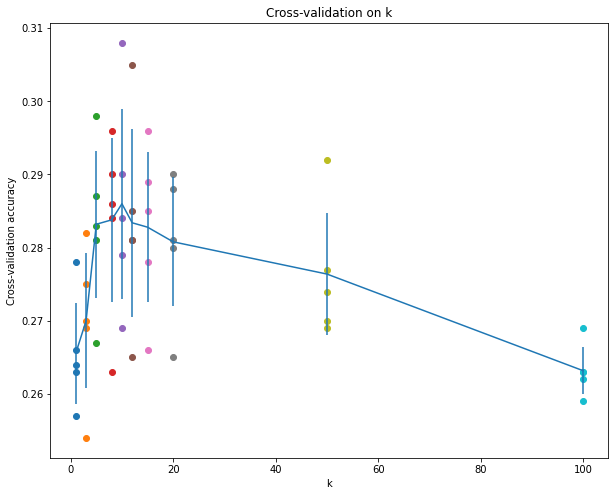

In [18]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [19]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 142 / 500 correct => accuracy: 0.284000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$ 2, 4


$\color{blue}{\textit Your Explanation:}$  
1. False. Shape of decision Boundary is different depending on training data and label. Let's say there are two classes, one is in circle shape and the other is outside of circle. Then, the decision boundary might be in the shape of circle.  
학습 데이터와 레이블에 따라서 결정 경계의 모양은 달라진다. 예를 들어 2개의 클래스를 구분하고자 할 때, 한 클래스는 원 모양으로 데이터가 모여 있고, 다른 클래스는 원 밖의 지역에 데이터가 모여 있다면, 결정 경계는 원의 테두리가 될 것이기 따문에 결정 경계가 선형이라는 말은 옳지 않다.

2. True. If you use a 1-NN, then each training data might look only exact same data to optimize. However, if you use a 5-NN, the model has to look five different training data which increases error. (It's because model have to consider the other 4 wrong data to optimize)  
1-NN을 학습에 사용한다면 하나의 데이터에 대해 최적화를 해 에러가 0이지만, 5-NN을 사용한다면 5개의 데이터에 대해 최적화를 해야 하며, 트레이닝에서 한 개의 맞는(동일한) 데이터와 4개의 다른 데이터를 최적화에 사용하기 때문에 다른 4개의 데이터에 의해 에러가 증가하게된다. 따라서 1-NN이 5-NN보다 트레이닝 에러가 작거나 같다.

3. False. For example, x_train = \[-10, -7, -5, -2, 0, 4\] and y_train = \[0, 0, 0, 0, 0, 1\]. If x_test = 3 and y_test = 0, a 1-NN predicts as 1 since the nearest x is 4, whereas a 5-NN predicts as 0 because majority of y for nearest 5 data are 0. Thus, a 1-NN will have higher test error than that of a 5-NN.  
학습 데이터가 x_train = \[-10, -7, -5, -2, 0, 4\], y_train = \[0, 0, 0, 0, 0, 1\]라고 가정하고, x_test = 3, y_test = 0라고 하자. 1-NN을 사용한다면 가장 가까운 데이터가 4이고 레이블이 1이기 때문에 1이라고 예측할 것이고, 5-NN을 사용한다면 가까운 5개의 데이터 중 대부분이 0이기 때문에 0이라고 예측할 것이다. 1-NN일 경우 레이블과 예측값이 다르기 때문에 에러가 생기지만, 5-NN을 사용할 경우 레이블과 예측값이 같기 때문에 에러는 0이다. 위의 예시와 같은 경우가 존재하기 때문에 1-NN에서 5-NN보다 무조건 테스트 에러가 작을 것이라는 가정은 옳지 않다.


4. True. Because classifier has to calculate distance between test example and every train data, and sort by distance, it has to go through all data which implies that executing time is proportional to the size of the training set. More the number of training set, more the time needed to classify a test example.  
Classifier가 테스트 데이터를 예측할 때, 모든 학습 데이터와의 거리를 계산하고, 거리에 따라 정렬을 하기 때문에 모든 학습 데이터를 봐야 한다. 따라서, 학습 데이터의 크기가 커진다면, 연산해야하는 값이 증가하므로, 데이터를 예측하기 위한 시간(연산하는 시간)이 증가한다.